Soft deadline: `30.03.2022 23:59`

In this homework you will understand the fine-tuning procedure and get acquainted with Huggingface Datasets library

In [21]:
! pip install datasets
! pip install transformers

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


For our goals we will use [Datasets](https://huggingface.co/docs/datasets/) library and take `yahoo_answers_topics` dataset - the task of this dataset is to divide documents on 10 topic categories. More detiled information can be found on the dataset [page](https://huggingface.co/datasets/viewer/).


In [22]:
from datasets import load_dataset

In [23]:
dataset = load_dataset('yahoo_answers_topics') # the result is a dataset dictionary of train and test splits in this case

Reusing dataset yahoo_answers_topics (/root/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902)


  0%|          | 0/2 [00:00<?, ?it/s]

# Fine-tuning the model** (20 points)

In [24]:
from transformers import (ElectraTokenizer, ElectraForSequenceClassification,
                          get_scheduler, pipeline, ElectraForMaskedLM, ElectraModel, Trainer,TrainingArguments, InputFeatures)

import torch
from torch.utils.data import DataLoader
from datasets import load_metric

from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

Fine-tuning procedure on the end task consists of adding additional layers on the top of the pre-trained model. The resulting model can be tuned fully (passing gradients through the all model) or partially.

**Task**: 
- load tokenizer and model
- look at the predictions of the model as-is before any fine-tuning


```
- Why don't you ask [MASK]?
- What is [MASK]
- Let's talk about [MASK] physics
```

- convert `best_answer` to the input tokens (supporting function for dataset is provided below) 

```
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
```

- define optimizer, sheduler (optional)
- fine-tune the model (write the training loop), plot the loss changes and measure results in terms of weighted F1 score
- get the masked word prediction (sample sentences above) on the fine-tuned model, why the results as they are and what should be done in order to change that (write down your answer)
- Tune the training hyperparameters (and write down your results).

**Tips**:
- The easiest way to get predictions is to use transformers `pipeline` function 
- Do not forget to set `num_labels` parameter, when initializing the model
- To convert data to batches use `DataLoader`
- Even the `small` version of Electra can be long to train, so you can take data sample (>= 5000 and set seed for reproducibility)
- You may want to try freezing (do not update the pretrained model weights) all the layers exept the ones for classification, in that case use:


```
for param in model.electra.parameters():
      param.requires_grad = False
```


In [25]:
MODEL_NAME = "google/electra-small-generator"
TOKENIZER_NAME = "google/electra-small-generator"

In [26]:
tokenizer = ElectraTokenizer.from_pretrained(TOKENIZER_NAME)
model = ElectraForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=10)

loading file https://huggingface.co/google/electra-small-generator/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/783baabf823412158ef5569d9f79d40622cbebe10f9368a923f009a05f7c27df.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/google/electra-small-generator/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/google/electra-small-generator/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/google/electra-small-generator/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/6509888bf1c7dd0be24a79d56757f6477c89b682006d884a767caf918033bef5.19eda9a6da5fb0e52a45200c95876729561dde16a69b9116953af6edca1d1e92
loading configuration file https://huggingface.co/google/electra-small-generator/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/ddf7554779ef5bd660812cf3b6c92a66e14e307bae0f85

In [27]:
predictor = pipeline("fill-mask", model=MODEL_NAME)

loading configuration file https://huggingface.co/google/electra-small-generator/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/ddf7554779ef5bd660812cf3b6c92a66e14e307bae0f8582015b43ce8f8de85c.e50e2a54975f5ef36835643600664f71c63e7f570a08222c48829a8d8e327dca
Model config ElectraConfig {
  "_name_or_path": "google/electra-small-generator",
  "architectures": [
    "ElectraForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4

In [28]:
print("Predictions for 'Why don't you ask [MASK]?'")
print(f"MASK can be: {[item['token_str'] for item in predictor('Why don`t you ask [MASK]?')]}")
print("======================================")
print("Predictions for 'What is [MASK]'")
print(f"MASK can be: {[item['token_str'] for item in predictor('What is [MASK]')]}")
print("======================================")
print("Predictions for 'Let's talk about [MASK] physics'")
print(f"MASK can be: {[item['token_str'] for item in predictor('Let`s talk about [MASK] physics')]}")

Predictions for 'Why don't you ask [MASK]?'
MASK can be: ['me', 'why', 'questions', 'them', 'yourself']
Predictions for 'What is [MASK]'
MASK can be: ['?', '.', '!', '-', '"']
Predictions for 'Let's talk about [MASK] physics'
MASK can be: ['quantum', 'theoretical', 'particle', 'nuclear', 'real']


In [29]:
NUM_ROWS = 5000

In [30]:
def tokenize_function(data, num_rows):
    return tokenizer(data["best_answer"][:num_rows], padding="max_length", truncation=True)

In [31]:
tokenized_train = tokenize_function(dataset["train"], NUM_ROWS)
tokenized_test = tokenize_function(dataset["test"], NUM_ROWS)
topics_train = dataset["train"]["topic"][:NUM_ROWS]
topics_test = dataset["test"]["topic"][:NUM_ROWS]

In [32]:
class DataSetImp(Dataset):
    def __init__(self, tokenized_data,topics,length):
      self.tokenized_data=tokenized_data
      self.labels=topics
      self.length=length

    def __len__(self):
      return (self.length)

    def __getitem__(self, id):
      return InputFeatures(
            input_ids=self.tokenized_data['input_ids'][id],
            token_type_ids=self.tokenized_data['token_type_ids'][id],
            attention_mask=self.tokenized_data['attention_mask'][id],
            label=self.labels[id])


In [33]:
training = DataSetImp(tokenized_train, topics_train, NUM_ROWS)
test = DataSetImp(tokenized_test, topics_test, NUM_ROWS)

In [34]:
np.random.seed(7)
torch.manual_seed(7)

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/NLP/hw4/output",
    overwrite_output_dir=True,
    evaluation_strategy="steps",
    num_train_epochs=5,
    do_train=True,
    do_eval=True)

using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [35]:
metric = load_metric('f1')

def compute_metrics(pred):
    predictions, label_ids = pred
    preds = np.argmax(predictions, axis=1)
    return metric.compute(
        predictions=preds, references=label_ids, average="weighted")

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training,
    eval_dataset=test,
    compute_metrics=compute_metrics
    )

In [ ]:
train_result = trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5000
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3125


Step,Training Loss,Validation Loss,F1
500,1.826200,1.556959,0.452080
1000,1.323100,1.398778,0.539183
1500,1.162800,1.379312,0.550924
2000,1.011600,1.437068,0.546228
2500,0.883000,1.458389,0.544384
3000,0.770600,1.459448,0.554506


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8
Saving model checkpoint to /content/drive/MyDrive/NLP/hw4/output/checkpoint-500
Configuration saved in /content/drive/MyDrive/NLP/hw4/output/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/NLP/hw4/output/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8
Saving model checkpoint to /content/drive/MyDrive/NLP/hw4/output/checkpoint-1000
Configuration saved in /content/drive/MyDrive/NLP/hw4/output/checkpoint-1000/config.json
Model weights saved in /content/drive/MyDrive/NLP/hw4/output/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8
Saving model checkpoint to /content/drive/MyDrive/NLP/hw4/output/checkpoint-1500
Configuration saved in /content/drive/MyDrive/NLP/hw4/output/checkpoint-1500/config.json
Model weights saved in /content/drive/MyDrive/NLP/hw4/output/checkpoint-1500/pytorch_model.bi

In [ ]:
train_result

TrainOutput(global_step=3125, training_loss=1.1476919702148438, metrics={'train_runtime': 1640.8097, 'train_samples_per_second': 15.236, 'train_steps_per_second': 1.905, 'total_flos': 735648921600000.0, 'train_loss': 1.1476919702148438, 'epoch': 5.0})

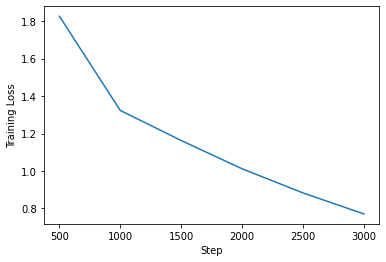

In [42]:
steps = [500, 1000,1500, 2000, 2500, 3000]
loss = [1.826200, 1.323100, 1.162800, 1.011600, 0.883000, 0.770600]
plt.plot(steps, loss)
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.show()

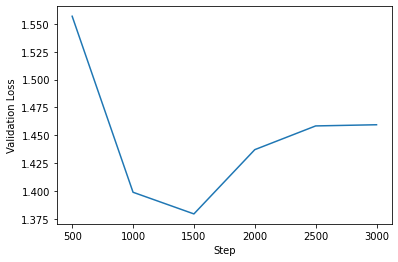

In [43]:
steps = [500, 1000, 1500, 2000, 2500, 3000]
loss = [1.556959, 1.398778, 1.379312, 1.437068, 1.458389, 1.459448]
plt.plot(steps, loss)
plt.xlabel("Step")
plt.ylabel("Validation Loss")
plt.show()

In [ ]:
evaluation_result = trainer.evaluate()
evaluation_result

***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8


{'epoch': 5.0,
 'eval_f1': 0.5530755680693935,
 'eval_loss': 1.458212971687317,
 'eval_runtime': 79.8064,
 'eval_samples_per_second': 62.652,
 'eval_steps_per_second': 7.831}

In [ ]:
PATH_TO_PRETRAINED_MODEL = "/content/drive/MyDrive/NLP/hw4"
model.save_pretrained(PATH_TO_PRETRAINED_MODEL)

Configuration saved in /content/drive/MyDrive/NLP/hw4/config.json
Model weights saved in /content/drive/MyDrive/NLP/hw4/pytorch_model.bin


In [ ]:
trained_model = ElectraForMaskedLM.from_pretrained(PATH_TO_PRETRAINED_MODEL)

In [ ]:
predictor_trained = pipeline("fill-mask", model=trained_model, tokenizer=tokenizer)

In [ ]:
print("Predictions for 'Why don't you ask [MASK]?'")
print(f"MASK can be: {[item['token_str'] for item in predictor_trained('Why don`t you ask [MASK]?')]}")
print("======================================")
print("Predictions for 'What is [MASK]'")
print(f"MASK can be: {[item['token_str'] for item in predictor_trained('What is [MASK]')]}")
print("======================================")
print("Predictions for 'Let's talk about [MASK] physics'")
print(f"MASK can be: {[item['token_str'] for item in predictor_trained('Let`s talk about [MASK] physics')]}")

Predictions for 'Why don't you ask [MASK]?'
MASK can be: ['a n k l e s', 'a i s l e s', '# # o p p e d', '# # t a n g l e d', 'c r o u c h e d']
Predictions for 'What is [MASK]'
MASK can be: ['f a u l t s', '# # u r i t i e s', '# # s i b i l i t y', '# # f e l t', '# # i c i e n c i e s']
Predictions for 'Let's talk about [MASK] physics'
MASK can be: ['f r a c t u r e', 'f r a c t u r e s', '# # u l a t e s', 'd o w n w a r d', '# # t u r e']


Result of prediction is different because the weights of the original model change during training.

In [36]:
device = 'cuda'
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [37]:
def model_init():
    return ElectraForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=10, return_dict=True)

In [41]:
trainer = Trainer(
    args=training_args,
    train_dataset=training, 
    eval_dataset=test,
    model_init=model_init,
    compute_metrics=compute_metrics,
)

loading configuration file https://huggingface.co/google/electra-small-generator/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/ddf7554779ef5bd660812cf3b6c92a66e14e307bae0f8582015b43ce8f8de85c.e50e2a54975f5ef36835643600664f71c63e7f570a08222c48829a8d8e327dca
Model config ElectraConfig {
  "architectures": [
    "ElectraForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "L

RuntimeError: ignored

In [ ]:
! pip install optuna

In [ ]:
trainer.hyperparameter_search(direction="maximize")

In [39]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=e4bafc4a3184e81c082cab6107f1a0acac383fd1e738311c3c68a981581ed44c
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Gen RAM Free: 10.5 GB  |     Proc size: 5.3 GB
GPU RAM Free: 16MB | Used: 11425MB | Util 100% | Total     11441MB
